Checking for NaNs and Infs in y_test:
False False
Checking for NaNs and Infs in reg_pred:
False False


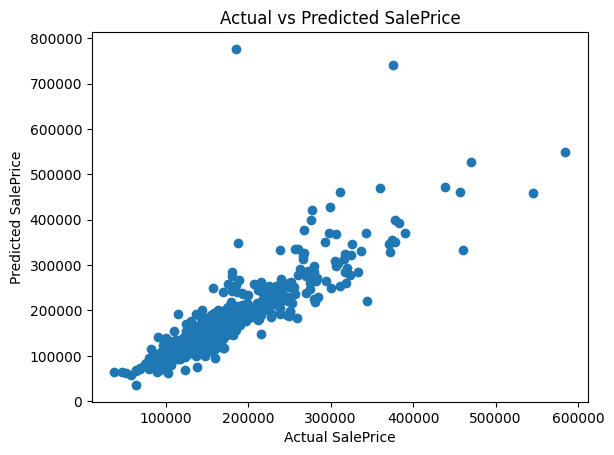

RMSE: 43358.79295730488
R^2: 0.6439460983821317
Cross-Validation RMSE: nan


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_10060\275131160.py:117: RuntimeWarning: invalid value encountered in scalar power
  print(f'Cross-Validation RMSE: {-cv_score.mean()**0.5}')


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline 

# Load the Ames house pricing dataset
Ames_dataset = pd.read_csv("AmesHousing.csv")

# Fill missing values for categorical columns
Ames_dataset['Alley'].fillna('No Alley', inplace=True)
Ames_dataset['Mas Vnr Type'].fillna('None', inplace=True)
Ames_dataset['Bsmt Qual'].fillna('No Basement', inplace=True)
Ames_dataset['Bsmt Cond'].fillna('No Basement', inplace=True)
Ames_dataset['Bsmt Exposure'].fillna('No Exposure', inplace=True)
Ames_dataset['BsmtFin Type 1'].fillna('No Basement', inplace=True)
Ames_dataset['BsmtFin Type 2'].fillna('No Basement', inplace=True)
Ames_dataset['Garage Yr Blt'].fillna(0, inplace=True)
Ames_dataset['Garage Finish'].fillna('No Garage', inplace=True)
Ames_dataset['Garage Qual'].fillna('No Garage', inplace=True)
Ames_dataset['Garage Cond'].fillna('No Garage', inplace=True)
Ames_dataset['Fence'].fillna('No Fence', inplace=True)
Ames_dataset['Misc Feature'].fillna('None', inplace=True)
Ames_dataset['Fireplace Qu'].fillna('No Fireplace', inplace=True)
Ames_dataset['Garage Type'].fillna('No Garage', inplace=True)
Ames_dataset['Pool QC'].fillna('No Pool', inplace=True)
Ames_dataset['Electrical'].fillna(Ames_dataset['Electrical'].mode()[0], inplace=True)

# Fill missing values for numerical columns
Ames_dataset['Mas Vnr Area'].fillna(Ames_dataset['Mas Vnr Area'].median(), inplace=True)
Ames_dataset['BsmtFin SF 1'].fillna(0, inplace=True)
Ames_dataset['BsmtFin SF 2'].fillna(0, inplace=True)
Ames_dataset['Bsmt Unf SF'].fillna(0, inplace=True)
Ames_dataset['Total Bsmt SF'].fillna(0, inplace=True)
Ames_dataset['Bsmt Full Bath'].fillna(0, inplace=True)
Ames_dataset['Bsmt Half Bath'].fillna(0, inplace=True)
Ames_dataset['Garage Cars'].fillna(0, inplace=True)
Ames_dataset['Garage Area'].fillna(0, inplace=True)

# Using k-NN imputer for Lot Frontage
imputer = KNNImputer(n_neighbors=5)
Ames_dataset[['Lot Frontage']] = imputer.fit_transform(Ames_dataset[['Lot Frontage']])

# Feature Engineering
Ames_dataset['TotalFinishedSF'] = Ames_dataset['BsmtFin SF 1'] + Ames_dataset['BsmtFin SF 2'] + Ames_dataset['1st Flr SF'] + Ames_dataset['2nd Flr SF']
Ames_dataset['TotalBath'] = Ames_dataset['Full Bath'] + Ames_dataset['Half Bath'] + Ames_dataset['Bsmt Full Bath'] + Ames_dataset['Bsmt Half Bath']
Ames_dataset['HouseAge'] = Ames_dataset['Yr Sold'] - Ames_dataset['Year Built']
Ames_dataset['RemodAge'] = Ames_dataset['Yr Sold'] - Ames_dataset['Year Remod/Add']
Ames_dataset['HasPool'] = Ames_dataset['Pool Area'].apply(lambda x: 1 if x > 0 else 0)
Ames_dataset['HasGarage'] = Ames_dataset['Garage Area'].apply(lambda x: 1 if x > 0 else 0)
Ames_dataset['HasFireplace'] = Ames_dataset['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Encode categorical variables
Ames_dataset_encoded = pd.get_dummies(Ames_dataset, drop_first=True)

# Define X and y
X = Ames_dataset_encoded.drop('SalePrice', axis=1)
y = Ames_dataset_encoded['SalePrice']

# Log transform y
y_log = np.log1p(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.18, random_state=22)

# Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Scale the dataset
scaler = StandardScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

# Try Ridge Regression with cross-validation
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_poly, y_train)

# Predict and evaluate
ridge_pred_log = ridge.predict(X_test_poly)
ridge_pred = np.expm1(ridge_pred_log)

# Check for NaNs and Infs in y_test and reg_pred
print("Checking for NaNs and Infs in y_test:")
print(np.any(np.isnan(y_test)), np.any(np.isinf(y_test)))
print("Checking for NaNs and Infs in reg_pred:")
print(np.any(np.isnan(ridge_pred)), np.any(np.isinf(ridge_pred)))

# Replace infinities with a large finite number if needed
ridge_pred[np.isinf(ridge_pred)] = 1e10
y_test[np.isinf(y_test)] = 1e10

# Plot the results
plt.scatter(np.expm1(y_test), ridge_pred)
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice')
plt.show()

# Evaluate the model
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), ridge_pred))
r2 = r2_score(np.expm1(y_test), ridge_pred)

print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

# Cross-validation score
cv_score = cross_val_score(ridge, X_train_poly, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-Validation RMSE: {-cv_score.mean()**0.5}')
